# Benchmark


In [20]:
from sigmaepsilon.solid.material import ElasticityTensor
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix
from sigmaepsilon.math.logical import isposdef, issymmetric
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion,
)

hooke = elastic_stiffness_matrix(E=210000, NU=0.3)
assert isposdef(hooke)
assert issymmetric(hooke, 1e-8)

yield_strength = 355.0

frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)
failure_model = HuberMisesHenckyFailureCriterion(yield_strength=yield_strength)
material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

In [21]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from numba import cuda

def measure_execution_times(store: dict, key: str, stresses, num_eval, device) -> float:
    store[key] = []
    for _ in range(num_eval):
        _t = time()
        #material.utilization(stresses=stresses, device=device)
        failure_model.utilization(stresses=stresses, device=device)
        store[key].append(time() - _t)

    return np.average(store[key])


def create_measurements(num_eval, num_points):
    times = {}

    stresses = tuple(np.random.rand(num_points) for _ in range(6))
    measure_execution_times(times, "v-cpu", stresses, num_eval, "cpu")

    stresses = tuple(np.random.rand(num_points) for _ in range(6))
    measure_execution_times(
        times, "v-cuda-numba", stresses, num_eval, "cuda"
    )
    
    stresses = tuple(np.random.rand(num_points) for _ in range(6))
    measure_execution_times(
        times, "guv-cuda-numba", stresses, num_eval, "cuda-guv"
    )
    
    stresses = tuple(np.random.rand(num_points) for _ in range(6))
    stresses = tuple(cuda.to_device(arr) for arr in stresses)
    measure_execution_times(
        times, "v-cuda-numba-kernel", stresses, num_eval, "cuda-kernel"
    )

    stresses = tuple(np.random.rand(num_points) for _ in range(6))
    stresses = tuple(cp.asarray(arr) for arr in stresses)
    measure_execution_times(
        times, "v-cuda-cupy", stresses, num_eval, "cuda-cp"
    )

    stresses = np.random.rand(num_points, 6)
    measure_execution_times(times, "b-cpu", stresses, num_eval, "cpu")

    times = {category: np.array(data) for category, data in times.items()}

    return times


def plot_histogram(data: dict, n_bins):
    max_execution_time = max(np.max(arr) for arr in data.values())
    bins = np.linspace(0, max_execution_time, n_bins)

    for category in data:
        plt.hist(
            data[category],
            alpha=0.8,
            label=category,
            density=True,
            histtype="barstacked",
            rwidth=0.8,
            bins=bins,
        )

    plt.xlabel("Execution Time")
    plt.ylabel("Frequency")
    plt.title("Execution Time Distributions")
    plt.legend()
    plt.show()

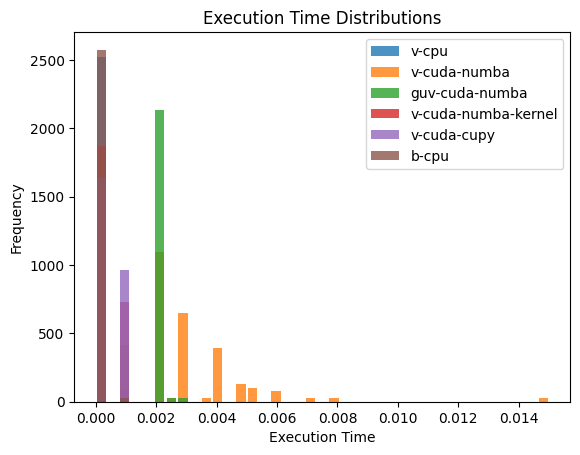

2.9907253269916767


In [22]:
times = create_measurements(100, 100)
plot_histogram(times, 40)
ratio = np.average(times["v-cpu"]) / np.average(times["b-cpu"])
print(ratio)

In [23]:
ratios = {cat: [] for cat in times}

nums = [1000, 10000, 50000, 100000, 500000, 1000000, 10000000]
nums = [80000, 200000, 500000, 1000000, 10000000]

for num_points in nums:
    times = create_measurements(10, num_points)
    avg_ref = np.average(times["b-cpu"])
    for category in times:
        ratio = np.average(times[category]) / avg_ref
        # print(f"Ratio for '{category}': {ratio}")
        ratios[category].append(ratio)

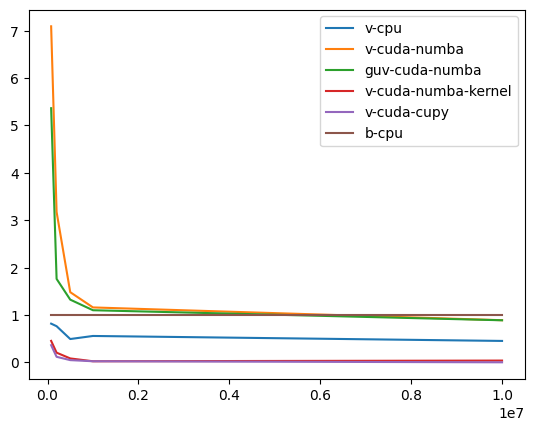

In [24]:
for category, y in ratios.items():
    plt.plot(nums, y, label=category)
plt.legend()

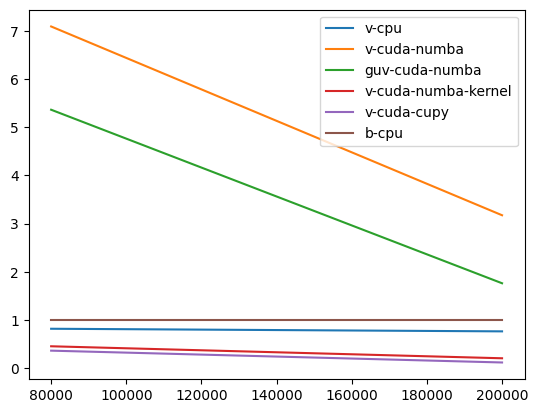

In [25]:
for category, y in ratios.items():
    plt.plot(nums[:2], y[:2], label=category)
plt.legend()

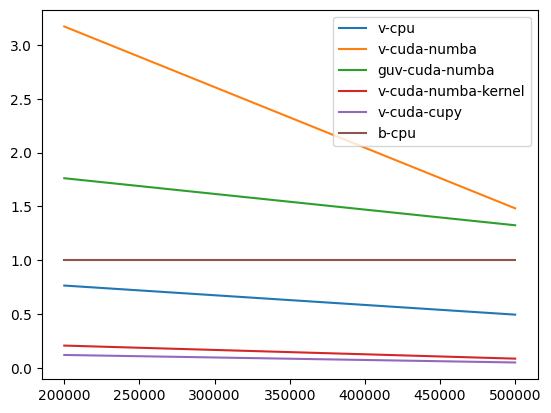

In [26]:
for category, y in ratios.items():
    plt.plot(nums[1:3], y[1:3], label=category)
plt.legend()

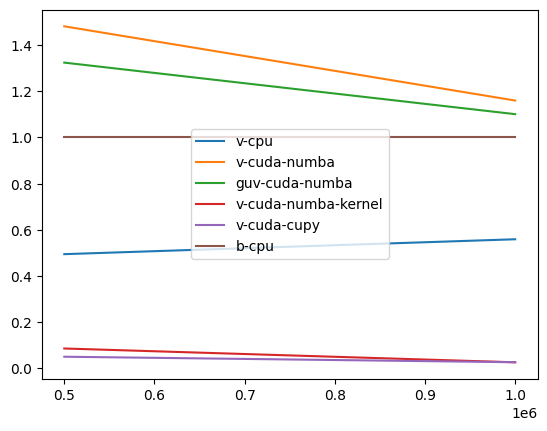

In [27]:
for category, y in ratios.items():
    plt.plot(nums[2:4], y[2:4], label=category)
plt.legend()

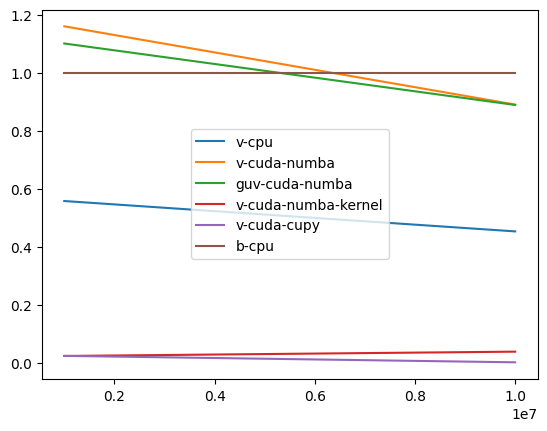

In [28]:
for category, y in ratios.items():
    plt.plot(nums[-2:], y[-2:], label=category)
plt.legend()